In [2]:
from model import DeepPose
from train import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
from train import GaussianNoise
from cuboid_pnp_solver import CuboidPNPSolver
from object_detector import ObjectDetector
import json
import yaml
from cuboid import Cuboid3d

/Users/kunalbhandarkar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kunalbhandarkar/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device being used: cpu


In [4]:
checkpoint_path = 'obj1_checkpoint_60.pth'
model = DeepPose()
load_model(checkpoint_path, model)

=> Loading checkpoint


FileNotFoundError: [Errno 2] No such file or directory: 'obj1_checkpoint_60.pth'

In [5]:
from dataloader import *

root = ''
modelsPath = 'lm_models/models/models_info.json'
annFileTrain = 'train_annotations_obj1.json'
annFileTest = 'test_annotations_obj1.json'

dataset_test = LineMODCocoDataset(root, annFileTest, modelsPath)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True, num_workers=4)
dataset_train = LineMODCocoDataset(root, annFileTrain, modelsPath)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


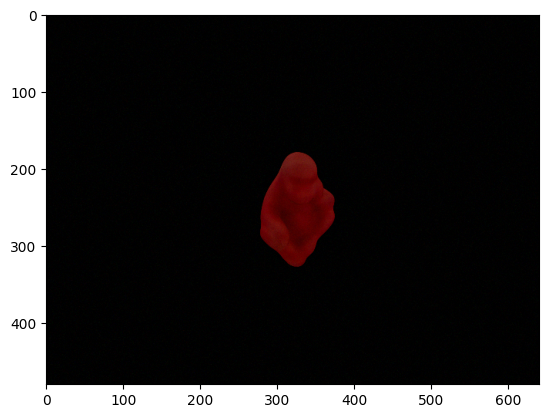

In [6]:
img_norm, target_dict = dataset_test[123]
gt_maps = target_dict['gt_maps']
img = target_dict['img']
gt_belief = gt_maps[:9]
gt_vector = gt_maps[9:]
plt.imshow(img)


In [8]:
cam_json_file = 'lm/camera.json'
with open(cam_json_file, 'r') as f:
    camera_params = json.load(f)

cx = camera_params['cx']
cy = camera_params['cy']
fx = camera_params['fx']
fy = camera_params['fy']

K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

In [ ]:
out = model(img_norm.unsqueeze(0))
print(out[0].shape, gt_belief.shape)

In [ ]:
beliefs, vectors = out[0][-1][0], out[1][-1][0]

(480, 640, 3)
(480, 640, 3)


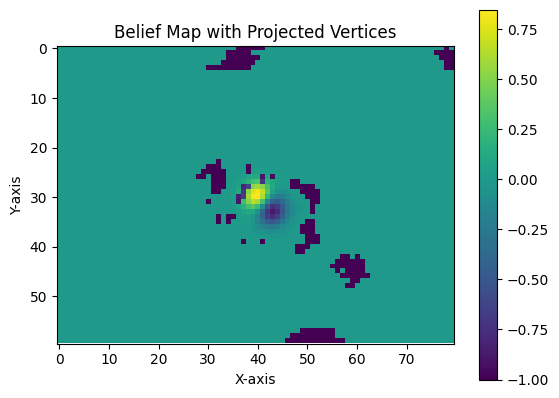

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2

# Convert gt_maps[2] to a numpy array if it's not already
belief_map = beliefs[8].detach().numpy()*255
belief_map = belief_map.astype(np.uint8)
print(img.shape)
belief_map_resized = resize(belief_map, (img.shape[0], img.shape[1]), anti_aliasing=True)

# Ensure belief_map_resized is 3 channels by repeating it along the last axis
belief_map_resized = np.repeat(belief_map_resized[:, :, np.newaxis], 3, axis=2)
print(belief_map_resized.shape)
# Combine the resized belief_map with the image
combined_image = img / 255 * 1.2 + belief_map_resized

# Display the combined image
plt.imshow(gt_belief[8] - belief_map/255)

# Overlay the projected vertices
#plt.scatter(proj_vertices[0, :], proj_vertices[1, :], c='blue', marker='o')

# Optional: Add labels or titles
plt.title('Belief Map with Projected Vertices')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

# Show the plot
plt.show()


In [8]:
import cv2
import numpy as np

# Load the image
image = np.require(img, requirements=['C_CONTIGUOUS'])

# Define the projected vertices for the objects
# Example format: [x, y] for 8 corners of a cube
# You should replace these with your actual vertices
vertices_list = [target_dict['projected_vertices'].T.astype(np.uint8)]
print(vertices_list, target_dict['projected_vertices'])
# Define colors for the bounding boxes and axes
box_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
axis_colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

# Function to draw the bounding box
def draw_bounding_box(image, vertices, color):
    
    # Draw the lines between vertices
    for i in range(4):
        start_point = tuple(vertices[i])
        end_point = tuple(vertices[(i + 1) % 4])
        cv2.line(image, start_point, end_point, color, 2)
        
        start_point_top = tuple(vertices[i + 4])
        end_point_top = tuple(vertices[(i + 1) % 4 + 4])
        cv2.line(image.copy(), start_point_top, end_point_top, color, 2)
        
        cv2.line(image.copy(), tuple(vertices[i]), tuple(vertices[i + 4]), color, 2)

# Function to draw the axes
def draw_axes(image, vertices, colors):
    origin = tuple(vertices[0])
    for i, color in enumerate(colors):
        cv2.line(image, origin, tuple(vertices[i + 1]), color, 2)

# Draw bounding boxes and axes for each object
for i, vertices in enumerate(vertices_list):
    color = box_colors[i % len(box_colors)]
    draw_bounding_box(image, vertices, color)
    draw_axes(image, vertices, axis_colors)

# Save the result
output_path = '/mnt/data/annotated_image.png'
cv2.imwrite(output_path, image)

# Optionally, display the image
cv2.imshow('Annotated Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


2024-06-08 16:04:33.866 Python[8553:3719153] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


In [ ]:
models = dataset_test.models
model1 = models['1']
with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

config_detect = lambda: None
config_detect.mask_edges = 1
config_detect.mask_faces = 1
config_detect.vertex = 1
config_detect.threshold = 0.5
config_detect.softmax = 1000
config_detect.thresh_angle = config["thresh_angle"]
config_detect.thresh_map = config["thresh_map"]
config_detect.sigma = config["sigma"]
config_detect.thresh_points = config["thresh_points"]

print(config['sigma'])
cuboid1 = Cuboid3d([model1['size_x'], model1['size_y'], model1['size_z']])
solver = CuboidPNPSolver(camera_intrinsic_matrix=K, cuboid3d=cuboid1)
od = ObjectDetector().detect_object_in_image(model, solver, img, config_detect)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# vector_fields = gt_maps[9:,:,:].numpy()
grid_width = 80
grid_height = 60
x = np.arange(grid_width)
y = np.arange(grid_height)
x, y = np.meshgrid(x, y)
vector_field_x_gt = gt_vector[6]
vector_field_y_gt = gt_vector[7]
vector_field_x = vectors[6].detach().numpy()
vector_field_y = vectors[7].detach().numpy()
#vertex_x = proj_vertices[0, :] // 8
#vertex_y = proj_vertices[1, :] // 8
#centroid_x = np.mean(proj_vertices[0, :]) // 8
#centroid_y = np.mean(proj_vertices[1, :]) // 8

vector_field_x.shape

In [ ]:
# Plot the vector field
plt.figure(figsize=(10, 8))
plt.quiver(x, y, vector_field_x_gt, vector_field_y_gt, angles='xy', scale=40, color='r')
plt.quiver(x, y, vector_field_x, vector_field_y, angles='xy', scale=40, color='b')
#plt.scatter([vertex_x], [vertex_y], color='b', label='Vertex')
#plt.scatter([centroid_x], [centroid_y], color='g', label='Centroid')
plt.xlim(0, grid_width)
plt.ylim(0, grid_height)
plt.legend()
plt.title('Vector Field Pointing Toward the Centroid')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

(2, 8) (9, 2)


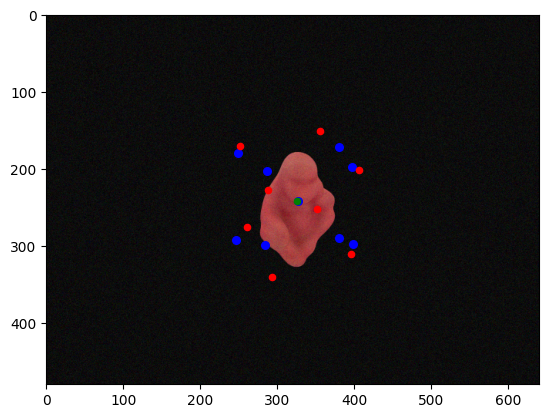

In [43]:
od_points = np.array(od[0][0]['projected_points'])
gt_points = np.array(projected_vertices)
centroid_x = np.mean(gt_points[0, :])
centroid_y = np.mean(gt_points[1, :])
print(projected_vertices.shape, od_points.shape)
plt.imshow(img)
plt.scatter(od_points[:,0], od_points[:,1], c='b', s=30)
plt.scatter(gt_points[0, :], gt_points[1, :], c='r', s=20)
plt.scatter([centroid_x], [centroid_y], c='g', s=20)
plt.show()

In [40]:
projected_vertices

array([[260.33756159, 293.35265255, 351.63975018, 251.43502997,
        395.43462149, 288.22695012, 355.04792726, 405.95177499],
       [274.92594606, 340.51892058, 252.21476944, 169.69290521,
        310.82525385, 227.77680409, 150.12641003, 201.18763461]])

In [ ]:
def run_inference(model, dataloader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for img, target in dataloader:
            img = img.to(device)
            output = model(img)
            

            # Assuming output contains the predicted pose
            predicted_pose = pnp(output)
            ground_truth_pose = target['pose']
            
            all_predictions.append(predicted_pose.to(torch.device('mps')).numpy())
            all_targets.append(ground_truth_pose.to(torch.device('mps')).numpy())
            
    return all_predictions, all_targets


In [ ]:
import numpy as np

def compute_add(vertices, pred_pose, gt_pose):
    # Transform vertices with ground truth pose
    vertices_gt = (gt_pose[:3, :3] @ vertices.T + gt_pose[:3, 3:4]).T
    
    # Transform vertices with predicted pose
    vertices_pred = (pred_pose[:3, :3] @ vertices.T + pred_pose[:3, 3:4]).T
    
    # Compute Euclidean distances
    distances = np.linalg.norm(vertices_gt - vertices_pred, axis=1)
    
    # Return average distance
    return np.mean(distances)


In [ ]:
# Assuming `model` is your trained model and `vertices` contains 3D points of the object model
device = torch.device('mps')
model.to(device)

predictions, targets = run_inference(model, dataloader)

add_scores = []
for pred_pose, gt_pose, target in zip(predictions, targets, dataset):
    vertices = dataset.create_3D_vertices(target['category_id'])
    add = compute_add(vertices, pred_pose, gt_pose)
    add_scores.append(add)

# Compute average ADD score
average_add = np.mean(add_scores)
print(f'Average ADD: {average_add}')


In [ ]:
img = dataset[0][0].numpy()
img

In [ ]:
# plt.imshow(dataset[0][0])
plt.imshow(img.transpose(1, 2, 0))

In [ ]:
import numpy as np

images, targets = next(iter(dataloader))
first_image = images[0]
first_target = targets[0]



In [ ]:


numpy_first_image = first_image.numpy()
plt.imshow(numpy_first_image)

In [ ]:
plt.imshow(first_target[0])

In [ ]:
# evaluate model on the first image/target pair

model.eval()
with torch.no_grad():
    pred_belief_maps, pred_vector_fields = model(first_image.unsqueeze(0))

In [ ]:
batch_size = pred_belief_maps.shape[0]
num_belief_maps = pred_belief_maps.shape[2]

# Plot each belief map in the batch
for i in range(batch_size):
    for j in range(num_belief_maps):
        belief_map = pred_belief_maps[i, 0, j].to(torch.device('mps')).numpy()

        plt.figure(figsize=(6, 5))
        plt.imshow(belief_map, cmap='hot')
        plt.colorbar()
        plt.title(f'Belief Map {j+1} (Batch {i+1})')
        plt.show()

In [ ]:
pred_vector_fields.shape